In [54]:
import numpy as np
import matplotlib.pyplot as plt

In [55]:
#Load the data
mixture_data = np.load("/content/drive/MyDrive/HW04/data/mixture_data.npz") #Load data
X = mixture_data["X"]
mixture_model = np.load("/content/drive/MyDrive/HW04/data/mixture_model.npz")
mu = mixture_model["mu"]
sigma = mixture_model["Sigma"]
pi = mixture_model["pi"]

In [56]:
print("X shape = ", X.shape)
print("mu shape = ", mu.shape)
print("sigma shape = ", sigma.shape)
print("pi shape = ", pi.shape)

X shape =  (10, 784)
mu shape =  (10, 784)
sigma shape =  (10, 784, 784)
pi shape =  (10, 1)


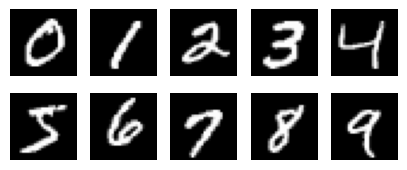

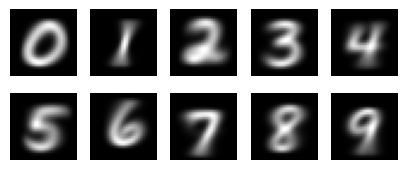

In [57]:
#Display the data
plt.figure(figsize=(5,2))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X[i,:].reshape(28,28),cmap="gray")
    plt.axis(False)
plt.show()

#Load the model
model = np.load("/content/drive/MyDrive/HW04/data/mixture_model.npz")
mu=model["mu"]
Sigma=model["Sigma"]
pi=model["pi"]

#Display the cluster means
plt.figure(figsize=(5,2))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(mu[i,:].reshape(28,28),cmap="gray")
    plt.axis(False)
plt.show()

In [58]:
import torch

In [59]:
sigma = torch.FloatTensor(sigma)
mu = torch.FloatTensor(mu)
pi = torch.FloatTensor(pi)
X = torch.FloatTensor(X)

In [60]:
# Computes and returns the log of joint probability of X=x and Z=z
def log_joint_probability(mu, sigma, pi, x):
  diff = (x-mu) # (x-mu)
  sigma_inv = torch.linalg.inv(sigma) # sigma^-1
  diff_reshaped = diff.reshape((10, 1, -1))
  diff_sigma = torch.bmm(diff_reshaped, sigma_inv) # (x-mu)sigma^-1
  diff_transposed = diff_reshaped.transpose(1, 2) #(x-mu)^T
  final_product = torch.bmm(diff_sigma, diff_transposed).view(10, 1)
    # (x-mu)sigma^-1(x-mu)^T
  pi_constant = torch.tensor(torch.pi)
  sigma_logdet = torch.logdet(2*pi_constant*sigma).reshape((10,1)) #log(|sigma|)
  sum = torch.log(pi)-1/2*sigma_logdet-1/2*final_product
  return sum

In [61]:
log_joint_probability(mu, sigma, pi, X[0,:])

tensor([[ 774.2565],
        [-560.7731],
        [ 617.3180],
        [ 577.6747],
        [ 398.5465],
        [ 498.7821],
        [ 528.8848],
        [ 197.0588],
        [ 504.1672],
        [ 448.2375]])

In [62]:
# Computes and returns log of conditional probability
# for each Z=z
def log_conditional_probability(mu, sigma, pi, x):
  log_joint = log_joint_probability(mu, sigma, pi, x)
  log_sum = torch.logsumexp(log_joint, 0)
  return torch.exp(log_joint-log_sum)

In [63]:
result = log_conditional_probability(mu, sigma, pi, X[5,:])
result

tensor([[0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [3.8559e-05],
        [0.0000e+00],
        [9.9994e-01],
        [0.0000e+00],
        [0.0000e+00],
        [3.0355e-33],
        [0.0000e+00]])

In [150]:
def predict_right_half(mu, sigma, pi, x):
  x_reshaped = x.reshape((28, 28))
  x_l =  x_reshaped [:, :14].reshape((1, 1, 392))
  x_r = x_reshaped[:, 14:].reshape((1, 1, 392))

  mu_reshaped = mu.reshape((10, 28, 28))
  mu_zl = mu_reshaped[:,:, :14].reshape((10, 1, 392))
  mu_zr = mu_reshaped[:,:, 14:].reshape((10, 1, 392))

  sigma_reshaped = sigma.reshape((10, 28, 28, 28, 28))
  sigma_zll = sigma_reshaped[:, :,:14, :, :14].reshape((10, 392, 392))
  sigma_zlr = sigma_reshaped[:, :,:14, :, 14:].reshape((10, 392, 392))
  sigma_zrl = sigma_reshaped[:, :,14:, :, :14].reshape((10, 392, 392))
  sigma_zrr = sigma_reshaped[:, :,14:, :, 14:].reshape((10, 392, 392))

  diff = (x_l-mu_zl)
  sigma_zll_inv = torch.linalg.inv(sigma_zll)
  diff_sigma = torch.bmm(diff, sigma_zll_inv)
  diff_sigma_zll = torch.bmm(diff, sigma_zll_inv)
  final_product = torch.bmm(diff_sigma_zll, sigma_zlr)
  sum = mu_zr + final_product
  log_conditional = log_conditional_probability(mu_zl, sigma_zll, pi, x_l)
  x_r_hat = torch.mul(log_conditional.view(10, 1, 1), sum.view(10, 392, 1))
  result = torch.sum(x_r_hat, axis=0).reshape((28, 14))
  y = torch.cat((x_reshaped [:, :14], result), dim=1)
  plt.imshow(y, cmap="gray")

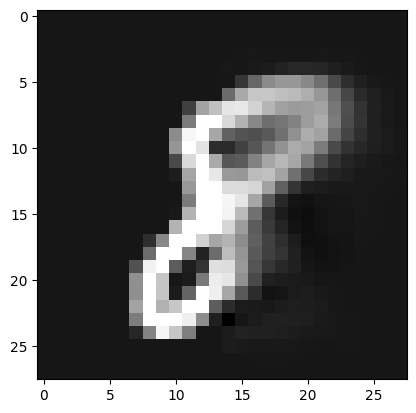

In [160]:
predict_right_half(mu, sigma, pi, X[8,:])

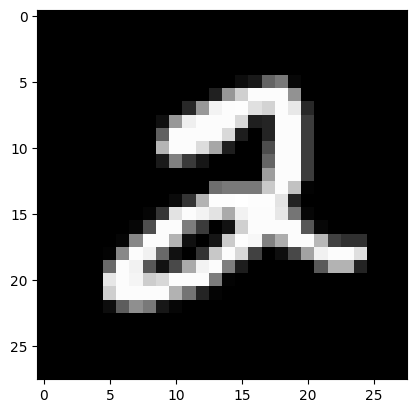

In [137]:
plt.imshow(X[2,:].reshape(28, 28), cmap="gray")

In [52]:
x = X
x_reshaped = x.reshape((10, 28, 28))
print("X_reshaped = ", x_reshaped.shape)
x_l =  x_reshaped [:, :, :14]
x_r = x_reshaped[:, :, 14:]
print("x_l shape = ", x_l.shape)
print("x_r shape = ", x_r.shape)

mu_reshaped = mu.reshape((10, 28, 28))
mu_zl = mu_reshaped[:,:, :14]
mu_zr = mu_reshaped[:,:, 14:]
print("mu_zl=", mu_zl.shape)
print("mu_zr = ", mu_zr.shape)

sigma_reshaped = sigma.reshape((10, 28, 28, 28, 28))
print("sigma_reshape=", sigma_reshaped.shape)
sigma_zll = sigma_reshaped[:, :,:14, :, :14]
print("sigma_zll=", sigma_zll.shape)

X_reshaped =  torch.Size([10, 28, 28])
x_l shape =  torch.Size([10, 28, 14])
x_r shape =  torch.Size([10, 28, 14])
mu_zl= torch.Size([10, 28, 14])
mu_zr =  torch.Size([10, 28, 14])
sigma_reshape= torch.Size([10, 28, 28, 28, 28])
sigma_zll= torch.Size([10, 28, 14, 28, 14])


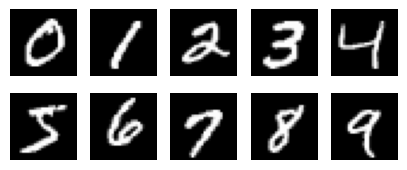

In [196]:
import numpy as np
import matplotlib.pyplot as plt

#Load the data
data = np.load("/content/drive/MyDrive/HW04/data/mixture_data.npz") #Load data
X = data["X"]

#Display the data
plt.figure(figsize=(5,2))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X[i,:].reshape(28,28),cmap="gray")
    plt.axis(False)
plt.show()

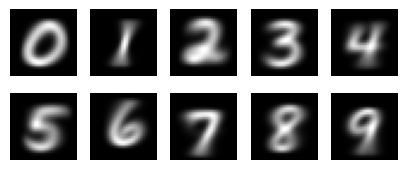

In [197]:
#Load the model
model = np.load("/content/drive/MyDrive/HW04/data/mixture_model.npz")
mu=model["mu"]
Sigma=model["Sigma"]
pi=model["pi"]

#Display the cluster means
plt.figure(figsize=(5,2))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(mu[i,:].reshape(28,28),cmap="gray")
    plt.axis(False)
plt.show()

In [102]:
diff = (X[0,:]-mu)
print("diff shape = ", diff.shape)
sigma_inv = torch.linalg.inv(sigma)
print("sigma inv shape = ", sigma_inv.shape) # (10, 784, 784)
diff_reshaped = diff.view(10, 1, 784)
print("diff reshaped shape = ", diff_reshaped.shape) # (10, 1, 784)
diff_sigma = torch.bmm(diff_reshaped, sigma_inv)
print("diff_sigma shape = ", diff_sigma.shape) # (10, 1, 784)
diff_transposed = diff_reshaped.transpose(1, 2)
print("diff_transposed shape = ", diff_transposed.shape) # (10, 784, 1)
final_product = torch.bmm(diff_sigma, diff_transposed).view(10, 1)
print("final product shape = ", final_product.shape)
# diff_sigma = torch.matmul(sigma_inv, diff)
# print("diff sigma shape = ", diff_sigma.shape)
# final_product = torch.matmul(diff, diff_sigma)
# print("final product = ", final_product.shape)

diff shape =  torch.Size([10, 784])
sigma inv shape =  torch.Size([10, 784, 784])
diff reshaped shape =  torch.Size([10, 1, 784])
diff_sigma shape =  torch.Size([10, 1, 784])
diff_transposed shape =  torch.Size([10, 784, 1])
final product shape =  torch.Size([10, 1])


In [53]:
torch.linalg.det(sigma)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [63]:
sigma.logdet().shape

torch.Size([10])

In [3]:
b = torch.tensor([1000, 10000, 1000000])
torch.exp(b)

tensor([inf, inf, inf])

In [8]:
a = torch.tensor([0.0000001, 0.00001, 0.000001])
torch.exp(a)

tensor([1.0000, 1.0000, 1.0000])